In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, f1_score

In [3]:
dataset= pd.read_csv("/content/sample_data/dataset.csv")
dataset.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [5]:
dataset = dataset.drop('Unnamed: 25', axis=1)
dataset.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [6]:
#filter the dataset to climinate columns that aren't relevant to a predictive model_
dataset = dataset[["FL_NUM", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME", "DEP_DELAY", "DEP_DEL15", "ARR_DELAY","ARR_DEL15"]]
dataset.isnull().sum()

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DELAY       107
DEP_DEL15       107
ARR_DELAY       188
ARR_DEL15       188
dtype: int64

In [7]:
dataset[dataset.isnull().any(axis=1)].head(10)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,-2.0,0.0,NaN,NaN
179,86,1,10,7,MSP,DTW,1632,NaN,NaN,NaN,NaN
184,557,1,10,7,MSP,DTW,912,-5.0,0.0,NaN,NaN
210,1096,1,10,7,DTW,MSP,1303,NaN,NaN,NaN,NaN
478,1542,1,22,5,SEA,JFK,723,NaN,NaN,NaN,NaN
481,1795,1,22,5,ATL,JFK,2014,NaN,NaN,NaN,NaN
491,2312,1,22,5,MSP,JFK,2149,NaN,NaN,NaN,NaN
499,423,1,23,6,JFK,ATL,1600,NaN,NaN,NaN,NaN
500,425,1,23,6,JFK,ATL,1827,NaN,NaN,NaN,NaN
501,427,1,23,6,JFK,SEA,1053,NaN,NaN,NaN,NaN


In [9]:
dataset['DEP_DEL15'] .mode()

0    0.0
Name: DEP_DEL15, dtype: float64

In [10]:
#replace the missing values with is.
dataset = dataset.fillna({'ARR_DEL15': 1})
dataset = dataset.fillna({'DEP_DEL15': 0})
dataset = dataset.fillna({'ARR_DELAY': 1})
dataset = dataset.fillna({'DEP_DELAY': 0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,-2.0,0.0,1.0,1.0
178,2839,1,9,6,DTW,JFK,1724,-4.0,0.0,-15.0,0.0
179,86,1,10,7,MSP,DTW,1632,0.0,0.0,1.0,1.0
180,87,1,10,7,DTW,MSP,1649,24.0,1.0,14.0,0.0
181,423,1,10,7,JFK,ATL,1600,11.0,0.0,7.0,0.0
182,440,1,10,7,JFK,ATL,849,-1.0,0.0,-14.0,0.0
183,485,1,10,7,JFK,SEA,1945,65.0,1.0,10.0,0.0
184,557,1,10,7,MSP,DTW,912,-5.0,0.0,1.0,1.0


In [11]:
import math

for index, row in dataset.iterrows():
    dataset.loc[index, 'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'] / 100)
dataset.head()    

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
0,1399,1,1,5,ATL,SEA,21,2.0,0.0,-41.0,0.0
1,1476,1,1,5,DTW,MSP,14,-1.0,0.0,4.0,0.0
2,1597,1,1,5,ATL,SEA,12,2.0,0.0,-33.0,0.0
3,1768,1,1,5,SEA,MSP,13,1.0,0.0,10.0,0.0
4,1823,1,1,5,SEA,DTW,6,-4.0,0.0,8.0,0.0


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['DEST'] = le.fit_transform(dataset['DEST'])
dataset['ORIGIN'] = le.fit_transform(dataset['ORIGIN'])


In [13]:
dataset.head(5)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
0,1399,1,1,5,0,4,21,2.0,0.0,-41.0,0.0
1,1476,1,1,5,1,3,14,-1.0,0.0,4.0,0.0
2,1597,1,1,5,0,4,12,2.0,0.0,-33.0,0.0
3,1768,1,1,5,4,3,13,1.0,0.0,10.0,0.0
4,1823,1,1,5,4,1,6,-4.0,0.0,8.0,0.0


In [14]:
dataset['ORIGIN'].unique()

array([0, 1, 4, 3, 2])

In [15]:
dataset = pd.get_dummies(dataset, columns=['ORIGIN', 'DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
0,1399,1,1,5,21,2.0,0.0,-41.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,14,-1.0,0.0,4.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,12,2.0,0.0,-33.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,13,1.0,0.0,10.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,6,-4.0,0.0,8.0,0.0,0,0,0,0,1,0,1,0,0,0


In [16]:
x = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8:9].values

In [17]:
x


array([[ 1.399e+03,  1.000e+00,  1.000e+00, ...,  2.000e+00,  0.000e+00,
        -4.100e+01],
       [ 1.476e+03,  1.000e+00,  1.000e+00, ..., -1.000e+00,  0.000e+00,
         4.000e+00],
       [ 1.597e+03,  1.000e+00,  1.000e+00, ...,  2.000e+00,  0.000e+00,
        -3.300e+01],
       ...,
       [ 1.823e+03,  1.200e+01,  3.000e+01, ...,  0.000e+00,  0.000e+00,
        -1.600e+01],
       [ 1.901e+03,  1.200e+01,  3.000e+01, ..., -1.000e+00,  0.000e+00,
        -5.000e+00],
       [ 2.005e+03,  1.200e+01,  3.000e+01, ..., -2.000e+00,  0.000e+00,
        -1.200e+01]])

In [18]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
z=oh.fit_transform(x[:,4:5]).toarray()
t=oh.fit_transform(x[:,5:6]).toarray()
#x=np.delete(x,[4,7],axis=1)

In [19]:
z

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
x=np.delete(x,[4,5],axis=1)

In [22]:
dataset.describe()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
count,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000
mean,1334.325617,6.628973,15.790758,3.960199,15.067314,8.379663,0.141483,-2.513311,0.139168,0.276022,0.195975,0.122340,0.225982,0.179681,0.286795,0.196866,0.116820,0.221975,0.177544
std,811.875227,3.354678,8.782056,1.995257,5.023534,36.596640,0.348535,38.905443,0.346138,0.447048,0.396967,0.327693,0.418246,0.383939,0.452285,0.397648,0.321219,0.415593,0.382146
min,7.000000,1.000000,1.000000,1.000000,0.000000,-16.000000,0.000000,-67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,624.000000,4.000000,8.000000,2.000000,11.000000,-3.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1267.000000,7.000000,16.000000,4.000000,15.000000,-1.000000,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2032.000000,9.000000,23.000000,6.000000,19.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2853.000000,12.000000,31.000000,7.000000,23.000000,645.000000,1.000000,615.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


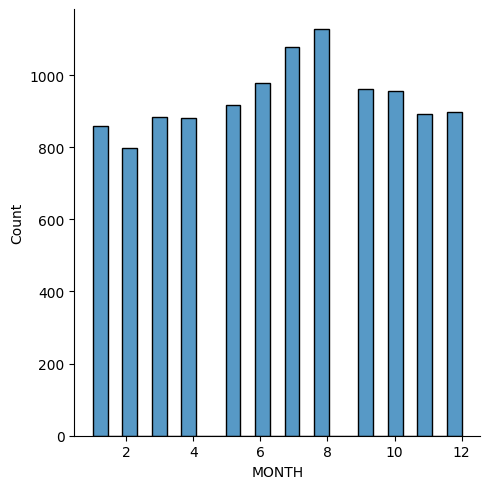

In [23]:
sns.displot(dataset.MONTH)

<Axes: xlabel='ARR_DELAY', ylabel='ARR_DEL15'>

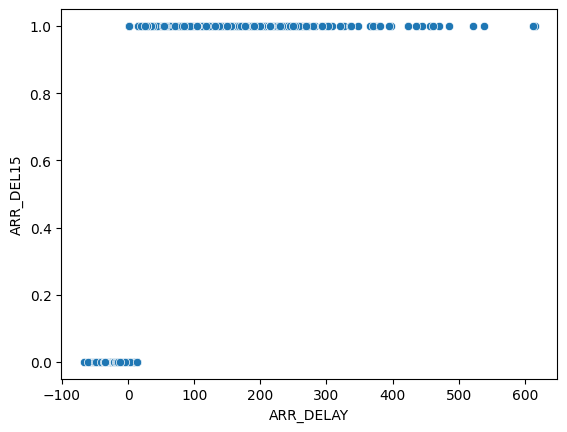

In [24]:
sns.scatterplot(x='ARR_DELAY',y='ARR_DEL15',data=dataset)

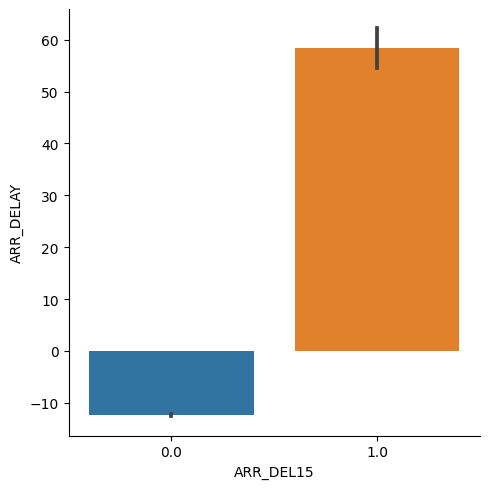

In [25]:
sns.catplot(x='ARR_DEL15',y="ARR_DELAY",kind='bar',data=dataset)

<Axes: >

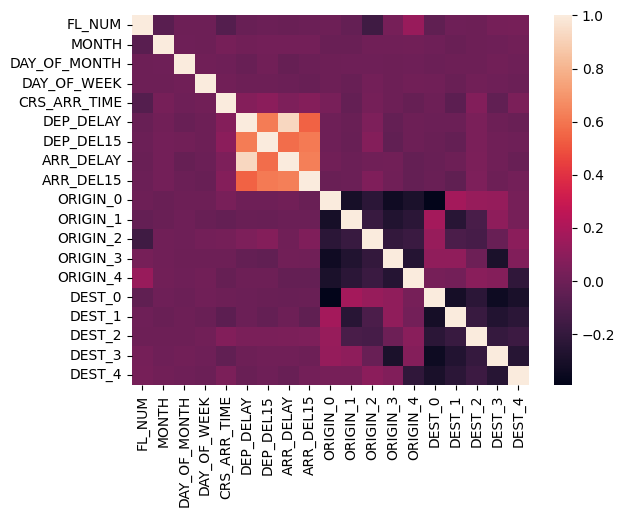

In [26]:
sns.heatmap(dataset.corr())

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [28]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y,test_y = train_test_split(dataset.drop('ARR_DEL15', axis=1), dataset['ARR_DEL15'], test_size=0.2, random_state=0)

In [29]:
x_test.shape

(2247, 6)

In [30]:
x_train.shape

(8984, 6)

In [31]:
y_test.shape

(2247, 1)

In [32]:
y_train.shape

(8984, 1)

In [33]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train = sc. fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [34]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [35]:
decisiontree = classifier.predict(x_test)

In [36]:
decisiontree

array([1., 0., 0., ..., 0., 0., 1.])

In [37]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy')

In [39]:
rfc.fit(x_train,y_train)

<ipython-input-39-b87bb2ba9825>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [40]:
y_predict = rfc.predict(x_test)

In [41]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [42]:
classification =Sequential()
classification.add(Dense(30,activation='relu'))
classification.add(Dense(128,activation='relu'))
classification.add(Dense(64,activation='relu'))
classification.add(Dense(32,activation='relu'))
classification.add(Dense(1,activation='sigmoid'))

In [43]:
classification.compile(optimizer='adam',loss='binary_craossentropy',metrics=['accuracy'])

In [45]:
classification.fit(x_train,y_train,batch_size=4,validation_split=0.2,epochs=100)


Epoch 1/100


TypeError: ignored

In [46]:
y_pred = classifier.predict([[129,99,1,0,0,0]])
print(y_pred)
(y_pred)

[0.]


array([0.])

In [47]:
y_pred=rfc.predict([[129,99,1,0,0,0]])
print(y_pred)
(y_pred)

[0.]


array([0.])

In [48]:
classification.save('fllight.h5')


In [49]:
y_pre=classification.predict(x_test)

71/71 [==============================] - 0s 2ms/step


In [50]:
y_pred

array([0.])

In [51]:
y_pred = (y_pred > 0.5)
y_pred

array([False])

In [52]:
def predict_exit(sample_value):
    sample_value = np.array(sample_value)
    sample_value = sample_value.reshape(1, -1)
    sample_value = sc.transform(sample_value)
    return classifier.predict(sample_value)
  

In [53]:
# convert list to numpy array
 sample_value = np.array(sample_value)

#reshape  because sample _value contains only 1 record
 sample_value = sample_value.reshape(1, -1)

#feature scaling
 sample_value = sc.transform(sample_value)
    return classifier.predict(sample_value)


IndentationError: ignored

In [54]:
test = classification.predict([[1, 1, 121.000000, 36.0, 0, 0, ]])
if test==1: 
    print('Prediction: Chance of delay')
else:
    print('Prediction: No chance of delay') 



1/1 [==============================] - 0s 61ms/step
Prediction: No chance of delay


In [55]:
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier


    dfs = []
models = [
          ('RF',RandomForestClassifier()),
          ('DecisionTree',DecisionTreeClassifier()),
          ('ANN',MLPClassifier())
       ]
results = []
    names = []
    scoring=['accuracy','precision_weighted','recall_weighted','f1_weighted','roc_auc']
    target_names=['no delay','delay']
    for name,model in models:
        kfold=model_selection.KFold(n_splits=5,shuffle=True,random_state=90210)
        cv_results=model_selection.cross_validate(model,x_train,y_train,cv=kfold,scoring=scoring)
        clf=model.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        print(name)
        print(classification_report(y_test,y_pred,target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df=pd.DataFrame(cv_results)
        this_df['model']=name
        dfs.append(this_df)
final=pd.concat(dfs,ignore_index=True)



 



IndentationError: ignored

In [56]:
y_predict_train=model.predict(x_train)

NameError: ignored

In [57]:
#randomforest accuracy
print('Training accuracy:',accuracy_score(y_train,y_predict_train))
print('Testing accuracy:',accuracy_score(y_test,y_predict))


NameError: ignored

In [58]:
#making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_predict)
cm

array([[1933,    3],
       [  73,  238]])

In [59]:
#accuracy score of desicionTree
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,decisiontree)


In [60]:
desacc

0.9643969737427681

In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,decisiontree)


In [62]:

cm

array([[1929,    7],
       [  73,  238]])

In [63]:
#calculate the Accuracy of ANN
from sklearn.metrics import accuracy_score,classification_report
score=accuracy_score(y_pred,y_test)
print('The accuracy for ANN model is:{}%'.format(score*100))




ValueError: ignored

In [64]:
#making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,
y_predict_train=model.predict(x_train)
cm

SyntaxError: ignored

In [65]:
#giving some parameters that can be used in randized search cv
parameters= { 'n_estimators':[1,20,30,55,68,74,90,120,115],
              'criterion': ['gini', 'entropy'],
             'max_features' : ["auto", "sqrt","log2"],
             'max_depth' : [2,5,8,10], 'verbose' : [1,2,3,4,6,8,9,10]
}



In [66]:
#performing the randomized cv
RCV = RandomizedSearchCV(estimator=rfc, param_distributions=parameters, cv=10, n_iter=4)

In [67]:
RCV.fit(x_train,y_train)


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | 

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 4

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]:

building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]:

building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]:

building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
buildi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tre

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
building tree 1 of 55
building tree 2 of 55


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 o

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [68]:
#getting the best paarmets from the giving list and best score  from them
bt_params = RCV.best_params_
bt_score = RCV.best_score_
bt_params

{'verbose': 10,
 'n_estimators': 68,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'gini'}

In [69]:
bt_score

0.9909831760605077

In [70]:
model=RandomForestClassifier(verbose=10,n_estimators=120,max_features='log2',max_depth=10,criterion='entropy')
RCV.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConve

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building t

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: 

building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: 

building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: 

building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building t

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: 

building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68


[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55 of 115
building tree 56 of 115
building tree 57 of 115
building tree 58 of 115
building tree 59 of 115
building tree 60 of 115
building tree 61 of 115
building tree 62 of 115
building tree 63 of 115
building tree 64 of 115
building tree 65 of 115
building tree 66 of 115
building tree 67 of 115
building tree 68 of 115
building tree 69 of 115
building tree 70 of 115
building tree 71 of 115
building tree 72 of 115
building tree 73 of 115
building tree 74 of 115
building tree 75 of 115
building tree 76 of 115
building tree 77 of 115
building tree 78

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55 of 115
building tree 56 of 115
building tree 57 of 115
building tree 58 of 115
building tree 59 of 115
building tree 60 of 115
building tree 61

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [71]:
y_predit_rf = RCV.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [72]:
RFC=accuracy_score(y_test,y_predict_rfc)
RFC


NameError: ignored

In [73]:
import pickle
pickle.dump(RCV,open('flight.pkl','wb'))



# New section